# Анализ и прогнозирование временных рядов методами искусственного интеллекта

## **Практическая работа 5. Поиск типичных подпоследовательностей временного ряда.**

In [1]:
%load_ext autoreload
%autoreload 2

Импорт библиотек и модулей

In [2]:
!pip install matrixprofile

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from modules.snippets import *
from scipy import signal

### **Задача 1. Поиск сниппетов одномерного временного ряда**

В первой задаче необходимо выполнить поиск сниппетов одномерного временного ряда. Расмотрите приведенный ниже пример использования алгоритма SnipperFinder и визуализации полученных результатов для искуственного врменного ряда.

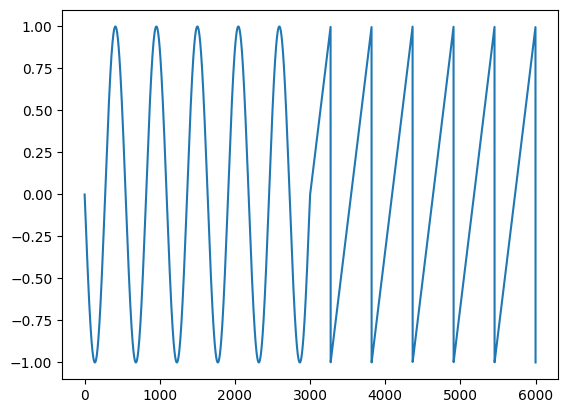

In [4]:
#Создание искусственного временного ряда
t = np.linspace(np.pi, 6 * 2 * np.pi, 3000)
ts = np.concatenate([np.sin(t), signal.sawtooth(t)])
plt.plot(ts)

In [5]:
#Поиск сниппетов
snp = snippets(ts, 600, 2)

In [6]:
!pip install -U kaleido

     ---------------------------------------- 65.9/65.9 MB 2.9 MB/s eta 0:00:00


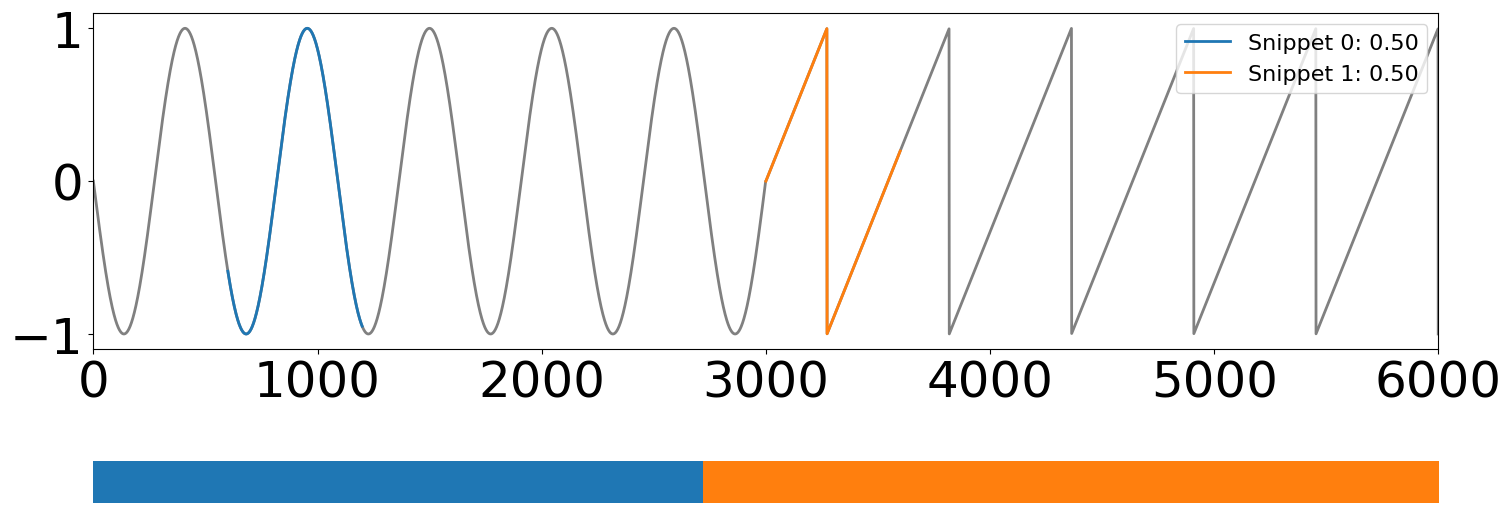

<AxesSubplot:>

In [7]:
#Визуализация результатов
plot_snippets(ts, snp)

Далее вам предстоит самостоятельно выполнить поиск top-$k$ типичных подпоследовательностей временного ряда (сниппетов) с помощью алгоритма SnippetFinder на наборе данных PAMAP. Описание набора данных находится в [README-файле](datasets/PAMAP/readme.md).

Выполните считывание временного ряда **показаний гироскопа на оси «X» (угол крена) на временном интервале от 950 сек. до 109 сек.** из файла *PAMAP.txt*, который располагается в директории *./datasets/PAMAP*. Затем выполните поиск сниппетов с помощью функции `snippets()` из модуля snippets.py.

In [9]:
import pandas as pd

df = pd.read_csv(r'data/PAMAP.txt', sep=' ', header=None).T
start_time = 850
end_time = 880

ts = df.loc[start_time < df.iloc[:, 0]].loc[df.iloc[:, 0] < end_time].iloc[:, 10].to_numpy()
snp = snippets(ts, 500, 2)

Выполните визулизацию временного ряда и найденных сниппетов с помощью функции `plot_snippets()` из модуля snippets.py.

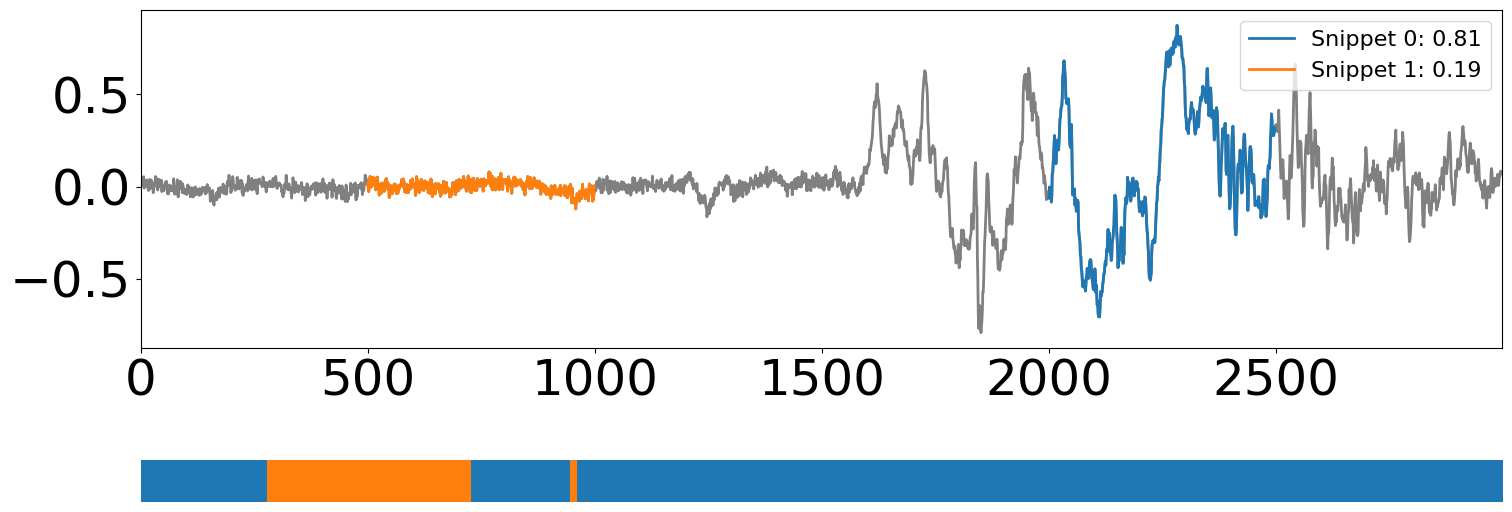

<AxesSubplot:>

In [10]:
plot_snippets(ts, snp)

Оцените точность разметки, полученной при помощи сниппетов.

In [11]:
from sklearn.metrics import accuracy_score

# get predicted labels (from plot_snippets)
labels_pred = np.zeros_like(ts)
for i, snippet in enumerate(snp):
    neighbors = np.array(snippet["neighbors"])
    for neighbor_index in neighbors:
        labels_pred[neighbor_index] = i

# get true labels
labels = df.loc[start_time < df.iloc[:, 0]].loc[df.iloc[:, 0] < end_time].iloc[:, 1].to_numpy()
labels = np.where(labels == 3, 1, labels)
labels = np.where(labels == 17, 0, labels)

accuracy_score(labels, labels_pred)

0.8112704234744915

❓ Проанализируйте и изложите содержательный смысл полученных результатов.

Поиск сниппетов позволяет делать кластеризацию во временных рядах 

### Задача 2. Разметка многомерного временного ряда

Выполните разметку многомерного временно ряда, используя **показания гироскопа по всем трем осям** из набора данных PAMAP. Используйте тот же временной интервал, что и в задаче 1.

In [12]:
start_time = 850
end_time = 880

ts = df.loc[start_time < df.iloc[:, 0]].loc[df.iloc[:, 0] < end_time].iloc[:, 10:13].to_numpy()
ts.shape

(2999, 3)

In [13]:
snp = []
snp.append(snippets(ts[:,0], 500, 2))
snp.append(snippets(ts[:,1], 500, 2))
snp.append(snippets(ts[:,2], 500, 2))

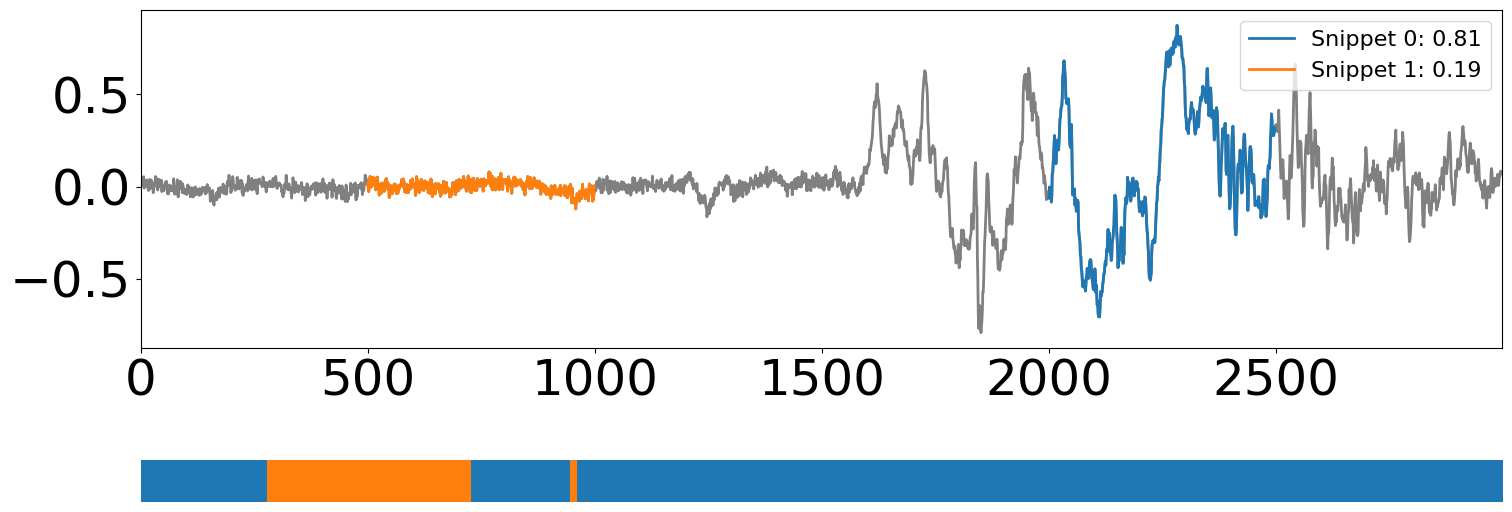

<AxesSubplot:>

In [14]:
plot_snippets(ts[:,0], snp[0])

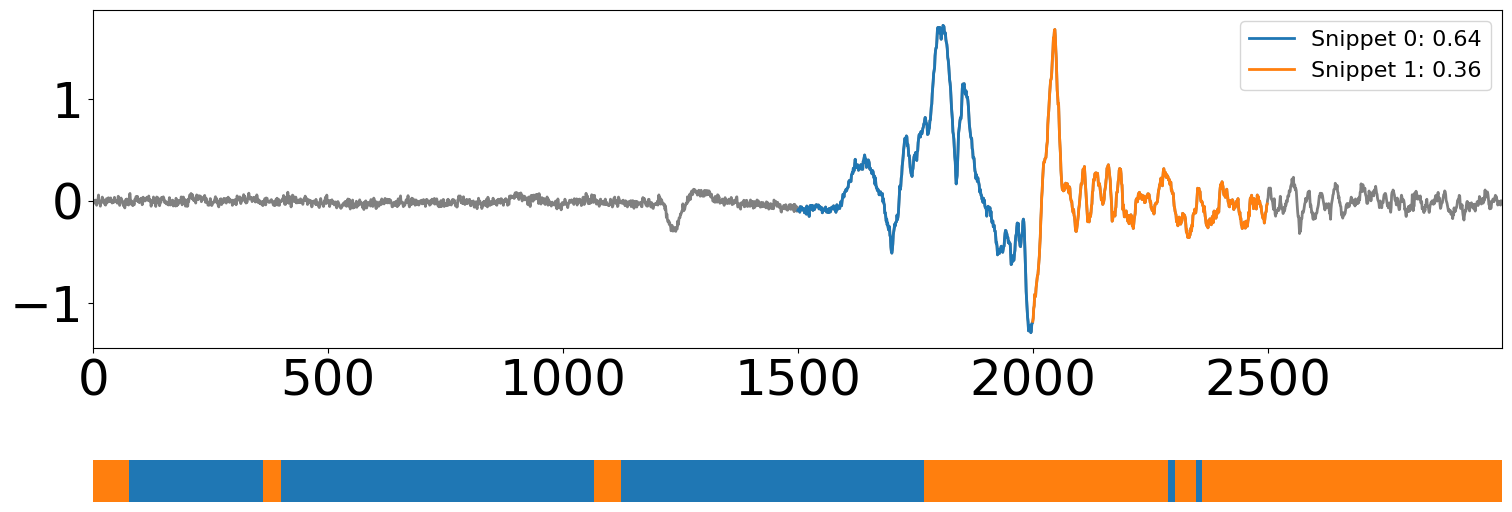

<AxesSubplot:>

In [15]:
plot_snippets(ts[:,1], snp[1])

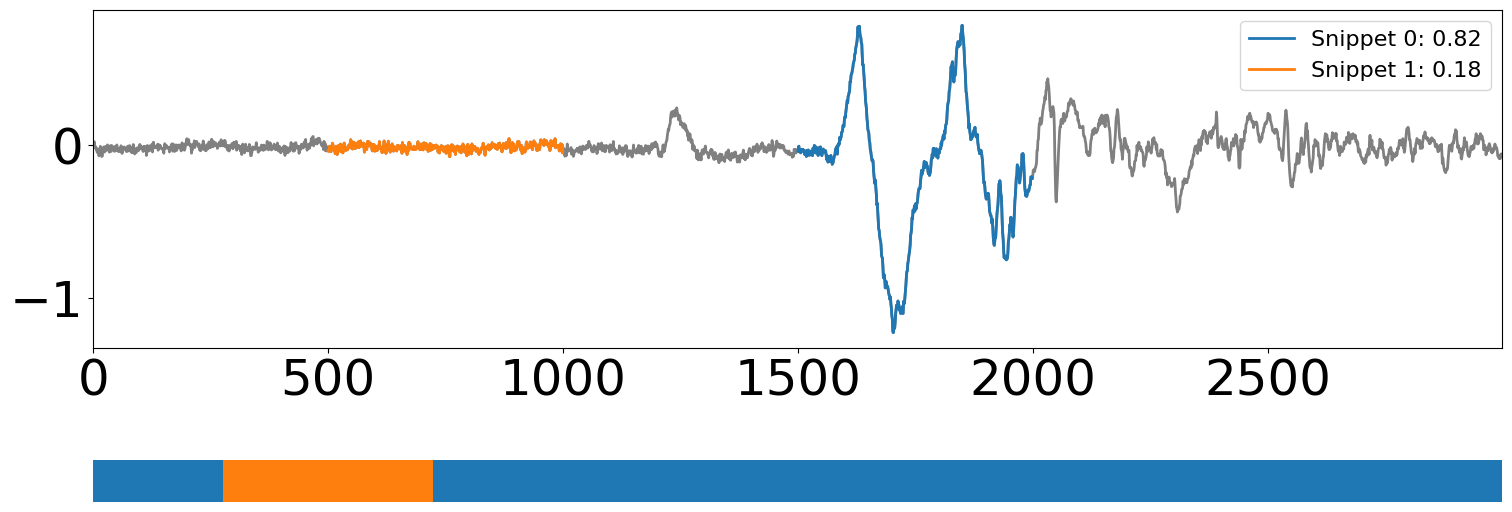

<AxesSubplot:>

In [16]:
plot_snippets(ts[:,2], snp[2])

Оцените точность разметки, полученной при помощи сниппетов.

In [17]:
from sklearn.metrics import accuracy_score


def get_1d_label(labels_3d):
    labels = [0 for _ in range(len(labels_3d))]
    for i in range(len(labels_3d)):
        counter = {}
        for label in labels_3d[i]:
            if label in counter:
                counter[label] += 1
            else:
                counter[label] = 1
        labels[i] = max(counter, key=counter.get)
    return labels


# get predicted labels (from plot_snippets)
labels_pred_3d = np.zeros_like(ts)
for i, snp_1d in enumerate(snp):
    for j, snippet in enumerate(snp_1d):
        neighbors = np.array(snippet["neighbors"])
        for neighbor_index in neighbors:
            labels_pred_3d[neighbor_index][i] = j
            
labels_pred_3d[:,1] = np.where(labels_pred_3d[:,1] == 0, 10, labels_pred_3d[:,1])
labels_pred_3d[:,1] = np.where(labels_pred_3d[:,1] == 1, 0, labels_pred_3d[:,1])
labels_pred_3d[:,1] = np.where(labels_pred_3d[:,1] == 10, 1, labels_pred_3d[:,1])

labels_pred = get_1d_label(labels_pred_3d)

# get true labels
labels = df.loc[start_time < df.iloc[:, 0]].loc[df.iloc[:, 0] < end_time].iloc[:, 1].to_numpy()
labels = np.where(labels == 3, 1, labels)
labels = np.where(labels == 17, 0, labels)

accuracy_score(labels, labels_pred)

0.8112704234744915

❓ Проанализируйте и изложите содержательный смысл полученных результатов. Сравните полученные разметки многомерного и одномерного рядов.

При анализе данных по всем осям, точность разметки вырастает, но для данной модели, в силу одинаковости данных, точность не выросла

## Задача 3. Подбор оптимального значения _k_


Разработайте программу, которая выполняет выполняет вычисление меры $change$ для различных значений $k$ с помощью алгоритма SnippetFinder. Проведите эксперименты, используя временной ряд из задания 2 (взяв 1 ≤ _k_ ≤ 9).

$Change_k = \frac{ProfileArea_{k-1}}{ProfileArea_k} - 1$

In [19]:
import pandas as pd

df = pd.read_csv(r'data/PAMAP.txt', sep=' ', header=None).T

In [20]:
start_time = 850
end_time = 880

ts = df.loc[start_time < df.iloc[:, 0]].loc[df.iloc[:, 0] < end_time].iloc[:, 10].to_numpy()
ts.shape

(2999,)

In [21]:
k = 9
prof_area = snippets(ts, 500, 2)[0]['snippet']

In [22]:
change = []
for i in range(1, 9):
    change.append(prof_area[i-1] / prof_area[i] - 1)

Выполните визуализацию результатов экспериментов в следующем виде: отображение столбчатых диаграм со значениями $ProfileArea$ и меры $change$ в зависимости от $k$.

In [24]:
!pip install plotly

   ---------------------------------------- 15.6/15.6 MB 1.6 MB/s eta 0:00:00


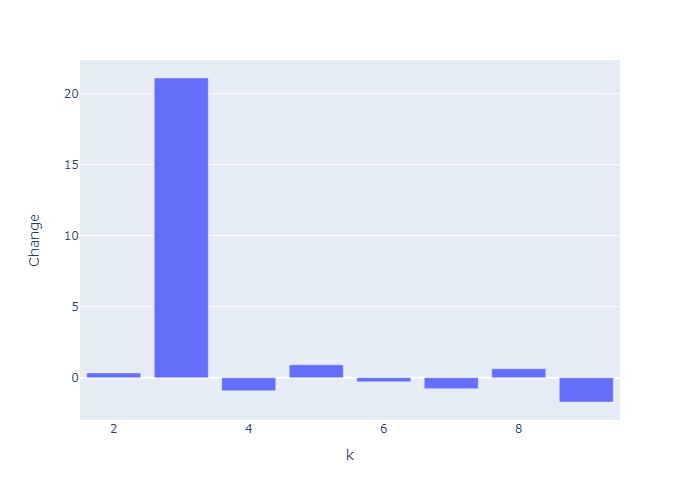

In [27]:
df = pd.DataFrame([range(2, 10), change]).T
df.columns = ['k', 'Change']
fig = px.bar(df, x='k', y='Change', labels={'k':'k', 'Change':'Change'})
fig.show("png")

❓ Проанализируйте и изложите содержательный смысл полученных результатов. Какое значение $k$ является наилучшим для используемого временного ряда?

Наилучшее значение k = 3 для данного многомерного ряда